In [3]:
import os
import gc
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from datetime import datetime, date
from collections import defaultdict, Counter
from multiprocessing import cpu_count, Pool

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import lightgbm as lgb

import warnings
warnings.simplefilter('ignore')

In [134]:
pd.options.display.max_columns = None

In [2]:
PATH = os.path.join('..', 'data')

KEY = 'card_id'

SEED = 18
# SEED = np.random.randint(9999)

NTHREAD = cpu_count()

NFOLD = 4

In [4]:
train = pd.read_csv(os.path.join(PATH, 'train.csv'))

In [5]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,mean_feature_1,mean_feature_2,mean_feature_3,first_active_month_year,first_active_month_weekday,first_active_month_month,first_active_month_weekofyear,first_active_month_quarter,first_active_month_is_month_start,elapsed_time,elapsed_time_feature_1,elapsed_time_feature_2,elapsed_time_feature_3
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,0.013145,0.008752,0.011428,2017,3,6,22,2,1,245,1225,490,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,0.010712,0.011385,0.010283,2017,6,1,52,1,1,396,1584,396,0
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,0.010610,0.008752,0.010283,2016,0,8,31,3,1,549,1098,1098,0
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,0.010712,0.014166,0.010283,2017,4,9,35,3,1,153,612,459,0
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,0.008058,0.014166,0.010283,2017,2,11,44,4,1,92,92,276,0


In [29]:
feature_1 = train.feature_1.unique()
feature_2 = train.feature_2.unique()
feature_3 = train.feature_3.unique()

In [30]:
feature_1, feature_2, feature_3

(array([5, 4, 2, 1, 3]), array([2, 1, 3]), array([1, 0]))

In [38]:
for i in feature_2:
    for j in feature_3:
       print(i, j, train.query('feature_2 == {} and feature_3 == {}'.format(i, j)).feature_1.unique())

2 1 [5 3]
2 0 [2 4 1]
1 1 [5 3]
1 0 [4 2 1]
3 1 [3]
3 0 [4 1 2]


In [45]:
not_outlier = train[train.target > -30]

In [36]:
outlier = train[train.target < -30]

In [57]:
train[train.target > 0].shape 

(97609, 19)

In [58]:
train[train.target < 0].shape 

(102678, 19)

In [39]:
for i in feature_2:
    for j in feature_3:
       print(i, j, outlier.query('feature_2 == {} and feature_3 == {}'.format(i, j)).feature_1.unique())

2 1 [5 3]
2 0 [4 2 1]
1 1 [3 5]
1 0 [2 4 1]
3 1 [3]
3 0 [2 1 4]


In [43]:
train.target.max()

17.965068399999996

In [44]:
train.target.min()

-33.21928095

In [46]:
not_outlier.target.min()

-17.60814651

In [48]:
submission = pd.read_csv('../submission/3690.csv')

In [51]:
submission.target.max()

2.6384192487648988

In [71]:
submission.query('target < -18')

,card_id,target
20556,C_ID_aae50409e7,-18.550455
32446,C_ID_ac114ef831,-21.253752
78078,C_ID_922f9c5ea6,-18.765014


In [53]:
submission.target.min()

-21.253752061086605

In [68]:
not_outlier.query('target < 0 and target > -18').shape

(100471, 19)

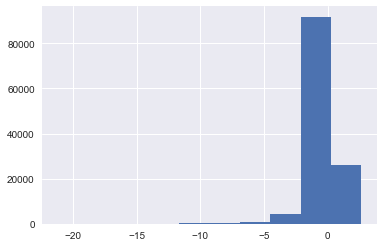

In [74]:
submission['target'].hist()

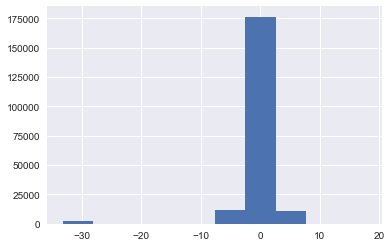

In [73]:
train['target'].hist()

In [79]:
new_merchant_transactions = pd.read_csv('../input/new_merchant_transactions.csv', usecols=['purchase_amount'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124439e10>]],
      dtype=object)

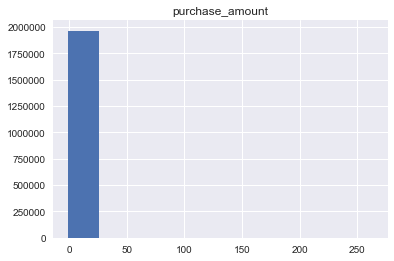

In [80]:
new_merchant_transactions.hist()

In [81]:
new_merchant_transactions.purchase_amount.max()

263.15749789

In [82]:
new_merchant_transactions.purchase_amount.min()

-0.74689277

In [83]:
new_merchant_transactions.purchase_amount.std()

0.6940042578502406

In [84]:
new_merchant_transactions.purchase_amount.mean()

-0.5509689991942271

In [85]:
new_merchant_transactions.purchase_amount.median()

-0.67484064

# Box plot

In [94]:
sns.set(style="whitegrid")

## train

In [87]:
train = pd.read_csv(os.path.join(PATH, 'train.csv'))

In [95]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,mean_feature_1,mean_feature_2,mean_feature_3,first_active_month_year,first_active_month_weekday,first_active_month_month,first_active_month_weekofyear,first_active_month_quarter,first_active_month_is_month_start,elapsed_time,elapsed_time_feature_1,elapsed_time_feature_2,elapsed_time_feature_3
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,0.013145,0.008752,0.011428,2017,3,6,22,2,1,245,1225,490,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,0.010712,0.011385,0.010283,2017,6,1,52,1,1,396,1584,396,0
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,0.010610,0.008752,0.010283,2016,0,8,31,3,1,549,1098,1098,0
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,0.010712,0.014166,0.010283,2017,4,9,35,3,1,153,612,459,0
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,0.008058,0.014166,0.010283,2017,2,11,44,4,1,92,92,276,0


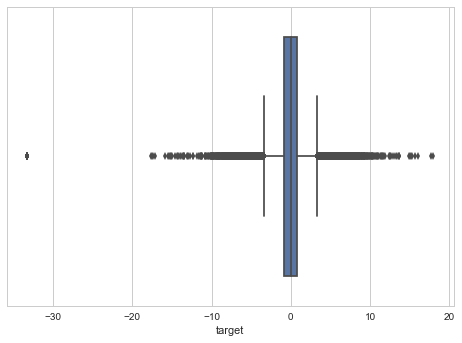

In [97]:
sns.boxplot(x='target', data=train)
plt.show()

## historical_transactions

In [88]:
historical_transactions = pd.read_csv(os.path.join(PATH, 'historical_transactions.csv'))

In [92]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,1,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,1,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,1,C_ID_4e6213e9bc,88,1,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,1,C_ID_4e6213e9bc,88,1,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,1,C_ID_4e6213e9bc,88,1,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


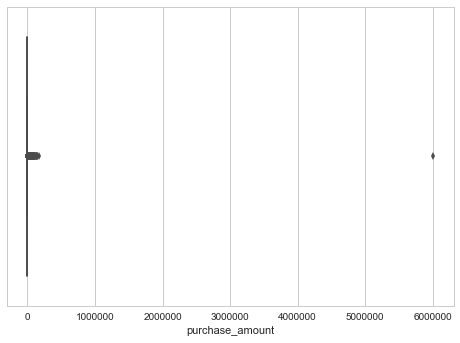

In [99]:
sns.boxplot(x='purchase_amount', data=historical_transactions)
plt.show()

In [158]:
installments = historical_transactions.installments.unique()

for i in installments:
    print(i, historical_transactions.query('installments == {}'.format(i)).category_3.unique())

0 [0]
1 [1]
5 [2]
3 [2]
4 [2]
2 [2]
-1 [3]
10 [2]
6 [2]
12 [2]
8 [2]
7 [2]
9 [2]
11 [2]
999 [2]


In [166]:
state_id = historical_transactions.state_id.unique()

for i in state_id:
    print(i, historical_transactions.query('state_id == {}'.format(i)).city_id.unique())

16 [ 88   3 226 331  47  51  60 110 267 270 312 343 210 214  65 224 104 100
 328   9 308 175  32 125 336  22  68 345  71]
9 [333  69 233  19 209 105 329  63  96 283 116 188 250 231 272 311  49 291
 163  24 109 314 131 340  62 331 213 230 155 106 279 140  23 265  21 173
 318  57  48 261 129 107 295 159  13 276 274  98 128 339 242 184 168  78
   7 111 285 115 238 255 117 271 183 174 138 149 294 309 186 298  20 325
 139 167 151 189 220 198  28 191  83  77 197 297 327  70   6 299 302 292
 199 330 244 266 170]
-1 [ -1 331 170  20  75 179 315 244 322]
11 [322  87 301   2 144]
15 [138 193 229 158 296  90 275 108 248 290 253 300  33 187  64  74 228 303
  29  35 153 252 236 326 341 219 165 237  54 254 331 118 319 302]
17 [330  30]
5 [278  57 143 170 247  12 181 150 145 107 331 117  96 260 313 289 199 287
 201 269 256 240 244 310  44 322 302 266 273]
24 [221  96  36 122 322 180 307  81 331 124 204 215 293]
19 [211  42 338  20 148  66 137 147  73 123  94  46 258 146 142 113  40 185]
23 [ 11 102 2

In [169]:
state_id = historical_transactions.state_id.unique()

for i in state_id:
    print(i, historical_transactions.query('state_id == {}'.format(i)).category_2.unique())

16 [1.]
9 [1.]
-1 [nan]
11 [3.]
15 [1.]
17 [3.]
5 [5.]
24 [2.]
19 [3.]
23 [2.]
3 [3.]
8 [3.]
18 [2.]
7 [3.]
4 [4.]
22 [4.]
13 [4.]
1 [3.]
10 [2.]
21 [5.]
20 [5.]
14 [4.]
2 [3.]
12 [1.]
6 [2.]


In [168]:
len(historical_transactions.city_id.unique())

308

In [167]:
len(state_id)

25

## new_merchant_transactions

In [180]:
new_merchant_transactions = pd.read_csv('../input/new_merchant_transactions.csv')

In [125]:
new_merchant_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


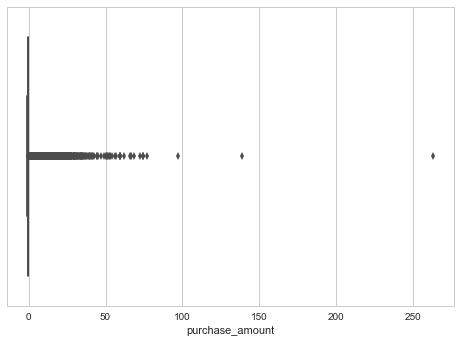

In [126]:
sns.boxplot(x='purchase_amount', data=new_merchant_transactions)
plt.show()

In [163]:
installments = new_merchant_transactions.installments.unique()

for i in installments:
    print(i, new_merchant_transactions.query('installments == {}'.format(i)).category_3.unique())

1 ['B']
-1 [nan]
3 ['C']
2 ['C']
12 ['C']
6 ['C']
0 ['A']
4 ['C']
10 ['C']
5 ['C']
9 ['C']
8 ['C']
7 ['C']
11 ['C']
999 ['C']


In [181]:
new_merchant_transactions.loc[new_merchant_transactions.installments == 999, 'installments'] = 13

In [188]:
new_merchant_transactions.query('purchase_amount > 80')

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
228412,Y,C_ID_a289e7edd4,-1,Y,10,C,210,M_ID_d3efd95cc7,2,139.053747,2018-04-19 11:51:18,NaN,-1,35
893769,Y,C_ID_765f1b0537,69,N,-1,NaN,637,M_ID_f7227b1aa8,1,97.009567,2018-03-20 10:35:53,1.0,9,37
1676431,Y,C_ID_ca850ecf25,69,N,9,C,210,M_ID_8c654cb52e,2,263.157498,2018-04-06 15:52:38,1.0,9,35


In [182]:
new_merchant_transactions[new_merchant_transactions.installments == 13]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
231851,Y,C_ID_8b3e96516a,174,N,13,C,840,M_ID_fcb061b2bf,1,-0.027138,2017-04-24 20:04:23,1.0,9,20
631387,Y,C_ID_726ae3c2bc,174,N,13,C,840,M_ID_fcb061b2bf,2,1.032186,2017-12-23 23:57:41,1.0,9,20


## merchants

In [261]:
merchants = pd.read_csv('../input/merchants.csv')

In [262]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


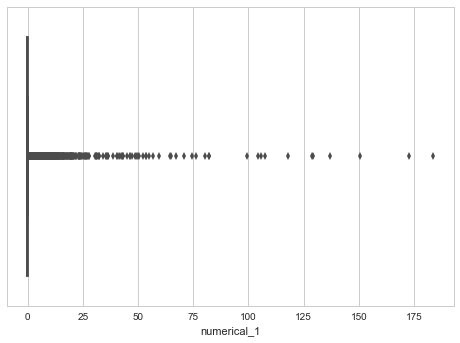

In [263]:
sns.boxplot(x='numerical_1', data=merchants)
plt.show()

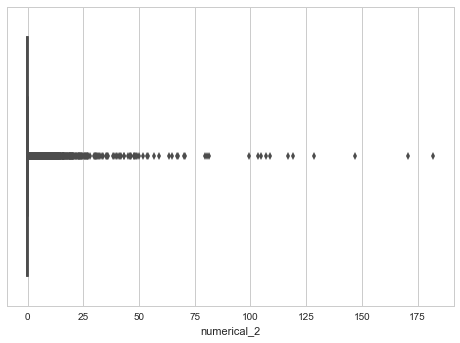

In [264]:
sns.boxplot(x='numerical_2', data=merchants)
plt.show()

In [265]:
merchants.query('merchant_id == "M_ID_0fc3e9bbb8"')

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
235493,M_ID_0fc3e9bbb8,4016,63,27,-0.037641,-0.047556,N,D,E,1.16,1.495726,3,1.31,1.696581,6,1.34,1.820513,12,Y,-1,24,2.0


In [266]:
sum(merchants.duplicated(subset='merchant_id'))

63

In [269]:
duplicated_merchants = merchants[merchants.duplicated(subset='merchant_id')].reset_index(drop=True)

In [272]:
historical_duplicated_merchansts = historical_transactions[historical_transactions.merchant_id.isin(duplicated_merchants.merchant_id)]

In [275]:
new_duplicated_merchanst = new_merchant_transactions[new_merchant_transactions.merchant_id.isin(duplicated_merchants.merchant_id)]

In [278]:
l = list(set(historical_duplicated_merchansts.card_id).union(set(new_duplicated_merchanst.card_id)))

In [281]:
train[train.card_id.isin(l)].nunique()

first_active_month        74
card_id               150986
feature_1                  5
feature_2                  3
feature_3                  2
target                148658
outliers                   2
outliers_count            14
outliers_mean             14
dtype: int64

In [282]:
train.nunique()

first_active_month        75
card_id               201917
feature_1                  5
feature_2                  3
feature_3                  2
target                197110
outliers                   2
outliers_count            14
outliers_mean             14
dtype: int64

# duplicated

In [215]:
PATH = os.path.join('..', 'remove_outlier_data')

features =  [f'f10{i}.pkl' for i in (2, 3)]
features += [f'f11{i}_{j}.pkl' for i in (1, 2) 
                               for j in ('Y', 'N')]

features += [f'f20{i}.pkl' for i in (2, 3)]
features += [f'f21{i}_{j}.pkl' for i in (1, 2)
             for j in ('Y', 'N')]

train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))

for f in features:
    print(f'Merge: {f}', end=' ')
    t = pd.read_pickle(os.path.join('..', 'remove_outlier_feature', f))
    train = pd.merge(train, t, on=KEY, how='left')
    test = pd.merge(test, t, on=KEY, how='left')
    print('Done!!')

Merge: f102.pkl Done!!
Merge: f103.pkl Done!!
Merge: f111_Y.pkl Done!!
Merge: f111_N.pkl Done!!
Merge: f112_Y.pkl Done!!
Merge: f112_N.pkl Done!!
Merge: f202.pkl Done!!
Merge: f203.pkl Done!!
Merge: f211_Y.pkl Done!!
Merge: f211_N.pkl Done!!
Merge: f212_Y.pkl Done!!
Merge: f212_N.pkl Done!!


In [191]:
cnt = Counter(train.columns)

In [192]:
cnt.most_common()

[('first_active_month', 1),
 ('card_id', 1),
 ('feature_1', 1),
 ('feature_2', 1),
 ('feature_3', 1),
 ('target', 1),
 ('first_active_month_year', 1),
 ('first_active_month_weekday', 1),
 ('first_active_month_month', 1),
 ('first_active_month_weekofyear', 1),
 ('first_active_month_quarter', 1),
 ('first_active_month_is_month_start', 1),
 ('elapsed_time', 1),
 ('days', 1),
 ('days_feature_1', 1),
 ('days_feature_2', 1),
 ('days_feature_3', 1),
 ('hist_transactions_count', 1),
 ('hist_category_1_sum', 1),
 ('hist_category_1_mean', 1),
 ('hist_category_1_nunique', 1),
 ('hist_category_2_nunique', 1),
 ('hist_category_2_median', 1),
 ('hist_category_3_nunique', 1),
 ('hist_category_3_median', 1),
 ('hist_merchant_id_nunique', 1),
 ('hist_state_id_nunique', 1),
 ('hist_subsector_id_nunique', 1),
 ('hist_city_id_nunique', 1),
 ('hist_merchant_category_id_nunique', 1),
 ('hist_installments_nunique', 1),
 ('hist_installments_sum', 1),
 ('hist_installments_min', 1),
 ('hist_installments_max', 1

In [201]:
for i in train.dtypes.unique():
    print(i)

object
int64
float64
int16
float16
int8
float32
datetime64[ns]


In [216]:
train.loc[:, train.dtypes == object].head()

,first_active_month,card_id
0,2017-06-01,C_ID_92a2005557
1,2017-01-01,C_ID_3d0044924f
2,2016-08-01,C_ID_d639edf6cd
3,2017-09-01,C_ID_186d6a6901
4,2017-11-01,C_ID_cdbd2c0db2


In [340]:
def duplicated(df):
    drop_cols_set = list()
    for ei, ci in enumerate(tqdm(df.columns)):
        ti = df[ci]
        for cj in df.columns[ei+1:]:
            tj = df[cj]
            if (ti.max() != tj.max()) or (ti.min() != tj.min()):
                continue
            if sum(tj != ti) == 0:
                print(ci, cj)
                drop_cols_set.append(cj)
                
    return drop_cols_set

In [218]:
drop_cols = set()
for c in tqdm(train.dtypes.unique()):
    drop_cols.union(duplicated(train.loc[:, train.dtypes == c]))

 78%|███████▊  | 142/183 [01:40<00:28,  1.42it/s]


100%|██████████| 8/8 [02:31<00:00, 18.90s/it]s]


In [219]:
drop_cols

set()

In [243]:
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1
train['outliers'].value_counts()

f = 'feature_1'
# for f in ['feature_1','feature_2','feature_3']:
order_label = train.groupby(['feature_1','feature_2','feature_3']).agg({
    'outliers': ['count', 'mean', 'std']
}).reset_index()

In [244]:
order_label.columns  = [f'{c[0]}_{c[1]}'.strip('_') for c in order_label.columns]

In [245]:
order_label

,feature_1,feature_2,feature_3,outliers_count,outliers_mean,outliers_std
0,1,1,0,6508,0.005378,0.073143
1,1,2,0,2833,0.011295,0.105697
2,1,3,0,2696,0.011128,0.104918
3,2,1,0,24502,0.013387,0.114926
4,2,2,0,24469,0.008133,0.089816
5,2,3,0,6826,0.009522,0.097124
6,3,1,1,24610,0.007070,0.083789
7,3,2,1,24417,0.007904,0.088556
8,3,3,1,24546,0.016459,0.127235
9,4,1,0,9194,0.009898,0.098999


In [330]:
train = pd.read_csv('../input/train.csv', parse_dates=['first_active_month'])
test = pd.read_csv('../input/test.csv', parse_dates=['first_active_month'])

train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1

feature_cols = ['feature_1', 'feature_2', 'feature_3']
order_label = train.groupby(feature_cols).agg({'outliers': ['count', 'mean']}).reset_index()
order_label.columns = [f'{c[0]}_{c[1]}'.strip('_') for c in order_label.columns]
train = pd.merge(train, order_label, on=feature_cols, how='left')
test = pd.merge(train, order_label, on=feature_cols, how='left')

In [331]:
drop_cols = set()
for c in tqdm(train.dtypes.unique()):
    drop_cols.union(duplicated(train.loc[:, train.dtypes == c]))

100%|██████████| 4/4 [00:00<00:00, 45.97it/s]]


In [255]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,outliers,outliers_count,outliers_mean
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,0,16197,0.009014
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,0,9194,0.009898
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,0,24469,0.008133
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,0,3768,0.009820
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,0,2696,0.011128


In [400]:
PATH = os.path.join('..', 'remove_outlier_data')

features = []

features +=  [f'f10{i}.pkl' for i in (2, 3)]
features += [f'f11{i}_{j}.pkl' for i in (1, 2) 
                               for j in ('Y', 'N')]
features += [f'f12{i}.pkl' for i in (1, 2)]


features += [f'f20{i}.pkl' for i in (2, 3)]
features += [f'f21{i}_{j}.pkl' for i in (1, 2)
                               for j in ('Y', 'N')]

features += [f'f40{i}.pkl' for i in (2, 3)]
features += [f'f41{i}_{j}.pkl' for i in (1, 2)
                               for j in ('Y', 'N')]
features += [f'f42{i}.pkl' for i in (1, 2)]

train = pd.read_csv(os.path.join(PATH, 'train.csv'))

for f in features:
    print(f'Merge: {f}', end=' ')
    t = pd.read_pickle(os.path.join('..', 'remove_outlier_feature', f))
    train = pd.merge(train, t, on=KEY, how='left')
    print('Done!!')

Merge: f102.pkl Done!!
Merge: f103.pkl Done!!
Merge: f111_Y.pkl Done!!
Merge: f111_N.pkl Done!!
Merge: f112_Y.pkl Done!!
Merge: f112_N.pkl Done!!
Merge: f121.pkl Done!!
Merge: f122.pkl Done!!
Merge: f202.pkl Done!!
Merge: f203.pkl Done!!
Merge: f211_Y.pkl Done!!
Merge: f211_N.pkl Done!!
Merge: f212_Y.pkl Done!!
Merge: f212_N.pkl Done!!
Merge: f402.pkl Done!!
Merge: f403.pkl Done!!
Merge: f411_Y.pkl Done!!
Merge: f411_N.pkl Done!!
Merge: f412_Y.pkl Done!!
Merge: f412_N.pkl Done!!
Merge: f421.pkl Done!!
Merge: f422.pkl Done!!


In [401]:
drop_cols = list()
for c in tqdm(train.dtypes.unique()):
    drop_cols.append(set(duplicated(train.loc[:, train.dtypes == c])))

 18%|█▊        | 72/398 [02:06<09:33,  1.76s/it]

hist_1_2017_rate union_1_2017_rate



 18%|█▊        | 73/398 [02:07<09:29,  1.75s/it]

hist_2_2017_rate union_2_2017_rate



 22%|██▏       | 86/398 [02:26<08:51,  1.70s/it]

hist_log_1_2017_rate union_log_1_2017_rate



 22%|██▏       | 87/398 [02:27<08:48,  1.70s/it]

hist_log_2_2017_rate union_log_2_2017_rate



 25%|██▌       | 100/398 [02:45<08:11,  1.65s/it]

cnt_count_1_2017_x cnt_count_1_2017_y



 26%|██▌       | 102/398 [02:47<08:06,  1.64s/it]

cnt_count_2_2017_x cnt_count_2_2017_y



 29%|██▊       | 114/398 [03:05<07:43,  1.63s/it]

cnt_max_1_2017_x cnt_max_1_2017_y



 29%|██▉       | 116/398 [03:09<07:39,  1.63s/it]

cnt_max_2_2017_x cnt_max_2_2017_y



 32%|███▏      | 129/398 [03:25<07:09,  1.60s/it]

cnt_mean_1_2017_x cnt_mean_1_2017_y



 33%|███▎      | 131/398 [03:28<07:04,  1.59s/it]

cnt_mean_2_2017_x cnt_mean_2_2017_y



 36%|███▌      | 143/398 [03:42<06:36,  1.55s/it]

cnt_min_1_2017_x cnt_min_1_2017_y



 36%|███▋      | 145/398 [03:44<06:31,  1.55s/it]

cnt_min_2_2017_x cnt_min_2_2017_y



 39%|███▉      | 157/398 [03:57<06:04,  1.51s/it]

cnt_std_1_2017_x cnt_std_1_2017_y



 40%|███▉      | 159/398 [03:59<06:00,  1.51s/it]

cnt_std_2_2017_x cnt_std_2_2017_y



 40%|████      | 161/398 [04:01<05:56,  1.50s/it]

cnt_std_3_2017_x cnt_std_3_2017_y



 41%|████      | 162/398 [04:03<05:54,  1.50s/it]

cnt_std_4_2017_x cnt_std_4_2017_y



 41%|████      | 163/398 [04:04<05:51,  1.50s/it]

cnt_std_5_2017_x cnt_std_5_2017_y



 42%|████▏     | 167/398 [04:07<05:42,  1.48s/it]

cnt_std_9_2017_x cnt_std_9_2017_y



 81%|████████  | 321/398 [06:10<01:28,  1.15s/it]


100%|██████████| 8/8 [06:46<00:00, 50.76s/it]s]


In [402]:
drop_cols

[set(),
 set(),
 set(),
 set(),
 {'cnt_count_1_2017_y',
  'cnt_count_2_2017_y',
  'cnt_max_1_2017_y',
  'cnt_max_2_2017_y',
  'cnt_mean_1_2017_y',
  'cnt_mean_2_2017_y',
  'cnt_min_1_2017_y',
  'cnt_min_2_2017_y',
  'cnt_std_1_2017_y',
  'cnt_std_2_2017_y',
  'cnt_std_3_2017_y',
  'cnt_std_4_2017_y',
  'cnt_std_5_2017_y',
  'cnt_std_9_2017_y',
  'union_1_2017_rate',
  'union_2_2017_rate',
  'union_log_1_2017_rate',
  'union_log_2_2017_rate'},
 set(),
 set(),
 set()]

In [284]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,outliers_mean,first_active_month_year,first_active_month_weekday,first_active_month_month,first_active_month_weekofyear,first_active_month_quarter,first_active_month_is_month_start,elapsed_time,days,days_feature_1,days_feature_2,days_feature_3,hist_transactions_count,hist_category_1_sum,hist_category_1_median,hist_category_2_nunique,hist_category_2_median,hist_category_3_nunique,hist_category_3_median,hist_merchant_id_nunique,hist_state_id_nunique,hist_subsector_id_nunique,hist_city_id_nunique,hist_merchant_category_id_nunique,hist_installments_nunique,hist_installments_sum,hist_installments_min,hist_installments_max,hist_installments_mean,hist_installments_median,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_purchase_month_median,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_max,hist_purchase_date_min,hist_month_diff_median,hist_month_diff_max,hist_month_diff_min,hist_month_diff_std,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_month_lag_min,hist_month_lag_max,hist_month_lag_mean,hist_month_lag_std,hist_purchase_amount_min_min,hist_purchase_amount_min_max,hist_purchase_amount_min_mean,hist_purchase_amount_min_std,hist_purchase_amount_max_min,hist_purchase_amount_max_max,hist_purchase_amount_max_mean,hist_purchase_amount_max_std,hist_purchase_amount_mean_min,hist_purchase_amount_mean_max,hist_purchase_amount_mean_mean,hist_purchase_amount_mean_std,hist_purchase_amount_std_min,hist_purchase_amount_std_max,hist_purchase_amount_std_mean,hist_purchase_amount_std_std,hist_installments_min_min,hist_installments_min_max,hist_installments_min_mean,hist_installments_min_std,hist_installments_max_min,hist_installments_max_max,hist_installments_max_mean,hist_installments_max_std,hist_installments_mean_min,hist_installments_mean_max,hist_installments_mean_mean,hist_installments_mean_std,hist_installments_std_min,hist_installments_std_max,hist_installments_std_mean,hist_installments_std_std,Y_hist_auth_transactions_count,Y_authorized_flag_x,Y_hist_auth_category_1_sum,Y_hist_auth_category_1_median,Y_hist_auth_category_2_nunique,Y_hist_auth_category_2_median,Y_hist_auth_category_3_nunique,Y_hist_auth_category_3_median,Y_hist_auth_merchant_id_nunique,Y_hist_auth_state_id_nunique,Y_hist_auth_subsector_id_nunique,Y_hist_auth_city_id_nunique,Y_hist_auth_merchant_category_id_nunique,Y_hist_auth_installments_nunique,Y_hist_auth_installments_sum,Y_hist_auth_installments_min,Y_hist_auth_installments_max,Y_hist_auth_installments_mean,Y_hist_auth_installments_median,Y_hist_auth_purchase_amount_sum,Y_hist_auth_purchase_amount_mean,Y_hist_auth_purchase_amount_max,Y_hist_auth_purchase_amount_min,Y_hist_auth_purchase_amount_std,Y_hist_auth_purchase_month_median,Y_hist_auth_purchase_month_max,Y_hist_auth_purchase_month_min,Y_hist_auth_purchase_month_std,Y_hist_auth_purchase_date_ptp,Y_hist_auth_purchase_date_max,Y_hist_auth_purchase_date_min,Y_hist_auth_month_diff_median,Y_hist_auth_month_diff_max,Y_hist_auth_month_diff_min,Y_hist_auth_month_diff_std,Y_hist_auth_purchase_date_diff,Y_hist_auth_purchase_date_average,Y_hist_auth_purchase_date_uptonow,N_hist_auth_transactions_count,N_authorized_flag_x,N_hist_auth_category_1_sum,N_hist_auth_category_1_median,N_hist_auth_category_2_nunique,N_hist_auth_category_2_median,N_hist_auth_category_3_nunique,N_hist_auth_category_3_median,N_hist_auth_merchant_id_nunique,N_hist_auth_state_id_nunique,N_hist_auth_subsector_id_nunique,N_hist_auth_city_id_nunique,N_hist_auth_merchant_category_id_nunique,N_hist_auth_installments_nunique,N_hist_auth_installments_sum,N_hist_auth_installments_min,N_hist_auth_installments_max,N_hist_auth_installments_mean,N_hist_auth_installments_median,N_hist_auth_purchase_amount_sum,N_hist_auth_purchase_amount_mean,N_hist_auth_purchase_amount_max

In [309]:
int_cols = []
for i in train.dtypes.unique():
    if 'int' in str(i):
        for j in train.loc[:, train.dtypes == i].columns.values:
            int_cols.append(j)

In [310]:
train_int = train[int_cols]

In [319]:
train_int = train_int.iloc[:, 14:]

In [320]:
train_int.nunique()

hist_transactions_count                     1023
hist_category_1_sum                         1014
hist_category_2_nunique                        6
hist_category_3_nunique                        4
hist_merchant_id_nunique                     313
hist_state_id_nunique                         20
hist_subsector_id_nunique                     34
hist_city_id_nunique                          58
hist_merchant_category_id_nunique             92
hist_installments_nunique                     13
hist_installments_sum                        966
hist_installments_min                         10
hist_installments_max                         14
hist_purchase_month_max                       11
hist_purchase_month_min                       11
hist_purchase_date_ptp                       422
hist_month_diff_max                           14
hist_month_diff_min                           14
hist_purchase_date_diff                      422
hist_purchase_date_uptonow                   391
hist_month_lag_min  

In [323]:
train_int.hist_merchant_id_nunique.max()

398

In [324]:
train_int.hist_merchant_category_id_nunique.max()

95

In [326]:
for i in train_int.columns:
    print('{}: unique={}, max={}'.format(i, len(train_int[i].unique()), train_int[i].max()))

hist_transactions_count: unique=1023, max=2912
hist_category_1_sum: unique=1014, max=2912
hist_category_2_nunique: unique=6, max=5
hist_category_3_nunique: unique=4, max=4
hist_merchant_id_nunique: unique=313, max=398
hist_state_id_nunique: unique=20, max=20
hist_subsector_id_nunique: unique=34, max=34
hist_city_id_nunique: unique=58, max=67
hist_merchant_category_id_nunique: unique=92, max=95
hist_installments_nunique: unique=13, max=13
hist_installments_sum: unique=966, max=2075
hist_installments_min: unique=10, max=10
hist_installments_max: unique=14, max=13
hist_purchase_month_max: unique=11, max=12
hist_purchase_month_min: unique=11, max=11
hist_purchase_date_ptp: unique=422, max=423
hist_month_diff_max: unique=14, max=12
hist_month_diff_min: unique=14, max=12
hist_purchase_date_diff: unique=422, max=423
hist_purchase_date_uptonow: unique=391, max=365
hist_month_lag_min: unique=13, max=-1
hist_month_lag_max: unique=12, max=0
hist_installments_min_min: unique=10, max=10
hist_instal

In [328]:
sum(train_int.hist_transactions_count != train_int.Y_hist_auth_transactions_count)

0

In [343]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [344]:
union = pd.read_csv('../remove_outlier_data/union.csv')

In [345]:
union.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,1,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,1,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,1,C_ID_4e6213e9bc,88,1,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,1,C_ID_4e6213e9bc,88,1,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,1,C_ID_4e6213e9bc,88,1,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


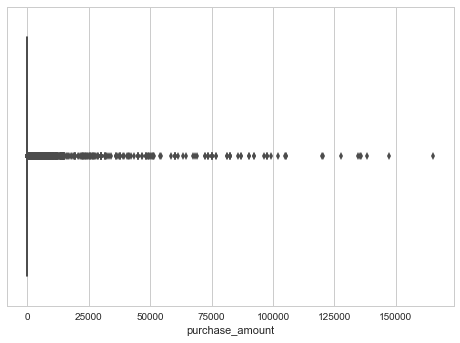

In [347]:
sns.boxplot(x='purchase_amount', data=union)
plt.show()

In [353]:
# del union['purchase_amount'], union['purchase_date']
del union['month_lag'], union['category_1'], union['category_2'], union['category_3']

In [354]:
union.head()

,authorized_flag,card_id,city_id,installments,merchant_category_id,merchant_id,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,80,M_ID_e020e9b302,16,37
1,1,C_ID_4e6213e9bc,88,0,367,M_ID_86ec983688,16,16
2,1,C_ID_4e6213e9bc,88,0,80,M_ID_979ed661fc,16,37
3,1,C_ID_4e6213e9bc,88,0,560,M_ID_e6d5ae8ea6,16,34
4,1,C_ID_4e6213e9bc,88,0,80,M_ID_e020e9b302,16,37


In [355]:
union.nunique()

authorized_flag              2
card_id                 325540
city_id                    308
installments                15
merchant_category_id       331
merchant_id             334633
state_id                    25
subsector_id                41
dtype: int64

In [361]:
gunion = union.groupby('card_id')['authorized_flag'].count().reset_index()

In [363]:
gunion.max(), gunion.min()

(card_id            C_ID_fffffd5772
 authorized_flag               5582
 dtype: object, card_id            C_ID_00007093c1
 authorized_flag                  2
 dtype: object)

In [364]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,outliers_mean,first_active_month_year,first_active_month_weekday,first_active_month_month,first_active_month_weekofyear,first_active_month_quarter,first_active_month_is_month_start,elapsed_time,days,days_feature_1,days_feature_2,days_feature_3,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_nunique,hist_category_3_nunique,hist_merchant_id_nunique,hist_state_id_nunique,hist_subsector_id_nunique,hist_city_id_nunique,hist_merchant_category_id_nunique,hist_installments_nunique,hist_installments_sum,hist_installments_min,hist_installments_max,hist_installments_mean,hist_installments_median,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_purchase_month_median,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_max,hist_purchase_date_min,hist_month_diff_median,hist_month_diff_max,hist_month_diff_min,hist_month_diff_std,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_month_lag_min,hist_month_lag_max,hist_month_lag_mean,hist_month_lag_std,hist_purchase_amount_min_min,hist_purchase_amount_min_max,hist_purchase_amount_min_mean,hist_purchase_amount_min_std,hist_purchase_amount_max_min,hist_purchase_amount_max_max,hist_purchase_amount_max_mean,hist_purchase_amount_max_std,hist_purchase_amount_mean_min,hist_purchase_amount_mean_max,hist_purchase_amount_mean_mean,hist_purchase_amount_mean_std,hist_purchase_amount_std_min,hist_purchase_amount_std_max,hist_purchase_amount_std_mean,hist_purchase_amount_std_std,hist_installments_mean_min,hist_installments_mean_max,hist_installments_mean_mean,hist_installments_mean_std,hist_installments_sum_min,hist_installments_sum_max,hist_installments_sum_mean,hist_installments_sum_std,hist_installments_std_min,hist_installments_std_max,hist_installments_std_mean,hist_installments_std_std,Y_hist_auth_transactions_count,Y_authorized_flag_x,Y_hist_auth_category_1_sum,Y_hist_auth_category_1_median,Y_hist_auth_category_2_nunique,Y_hist_auth_category_2_median,Y_hist_auth_category_3_nunique,Y_hist_auth_category_3_median,Y_hist_auth_merchant_id_nunique,Y_hist_auth_state_id_nunique,Y_hist_auth_subsector_id_nunique,Y_hist_auth_city_id_nunique,Y_hist_auth_merchant_category_id_nunique,Y_hist_auth_installments_nunique,Y_hist_auth_installments_sum,Y_hist_auth_installments_min,Y_hist_auth_installments_max,Y_hist_auth_installments_mean,Y_hist_auth_installments_median,Y_hist_auth_purchase_amount_sum,Y_hist_auth_purchase_amount_mean,Y_hist_auth_purchase_amount_max,Y_hist_auth_purchase_amount_min,Y_hist_auth_purchase_amount_std,Y_hist_auth_purchase_month_median,Y_hist_auth_purchase_month_max,Y_hist_auth_purchase_month_min,Y_hist_auth_purchase_month_std,Y_hist_auth_purchase_date_ptp,Y_hist_auth_purchase_date_max,Y_hist_auth_purchase_date_min,Y_hist_auth_month_diff_median,Y_hist_auth_month_diff_max,Y_hist_auth_month_diff_min,Y_hist_auth_month_diff_std,Y_hist_auth_purchase_date_diff,Y_hist_auth_purchase_date_average,Y_hist_auth_purchase_date_uptonow,N_hist_auth_transactions_count,N_authorized_flag_x,N_hist_auth_category_1_sum,N_hist_auth_category_1_median,N_hist_auth_category_2_nunique,N_hist_auth_category_2_median,N_hist_auth_category_3_nunique,N_hist_auth_category_3_median,N_hist_auth_merchant_id_nunique,N_hist_auth_state_id_nunique,N_hist_auth_subsector_id_nunique,N_hist_auth_city_id_nunique,N_hist_auth_merchant_category_id_nunique,N_hist_auth_installments_nunique,N_hist_auth_installments_sum,N_hist_auth_installments_min,N_hist_auth_installments_max,N_hist_auth_installments_mean,N_hist_auth_installments_median,N_hist_auth_purchase_amount_sum,N_hist_auth_purchase_amount_mean,N_hist_auth_purchase_amount_max,N_hist_auth_purchase_amount_min,N_hist_auth_purchase_amount_std,N_hist_auth_purchase_month_median,N_hist_auth_purchase_month_max,N_hist_auth_purchase_mo

In [375]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Dec 28 2018

@author: toshiki.ishikawa
"""

import os
import sys
import gc
import numpy as np
import pandas as pd

from tqdm import tqdm
from datetime import datetime, date
from sklearn.preprocessing import LabelEncoder
from multiprocessing import cpu_count, Pool


# utils.start(__file__)
#==============================================================================
NTHREAD = cpu_count()

PREF = 'f410'

KEY = 'card_id'

# stats = ['min', 'max', 'mean', 'median', 'std', 'var', 'skew', 'count']
stats = ['min', 'max', 'mean', 'std', 'count']


# =============================================================================
#
# =============================================================================
PATH = os.path.join('..', 'remove_outlier_data')

union = pd.read_csv(os.path.join(PATH, 'union.csv'))

union.purchase_date = pd.to_datetime(union.purchase_date)
union['month'] = union.purchase_date.dt.month
union['year'] = union.purchase_date.dt.year
union = union[['card_id', 'merchant_id', 'month', 'year']]

In [376]:
union['cnt'] = 1

ug = union.groupby(['card_id', 'merchant_id', 'month', 'year'])['cnt'].count().reset_index()
ugg = ug.groupby(['card_id', 'month', 'year']).agg({'cnt': stats})
del ug
gc.collect()

66

In [377]:
ugg.head()

cnt                              
                           min max      mean       std count
card_id         month year                                  
C_ID_00007093c1 1     2018   1   4  1.666667  1.211060     6
                2     2017   1   2  1.333333  0.577350     3
                      2018   1   3  1.714286  0.951190     7
                3     2017   4   6  5.000000  1.414214     2
                4     2017   2   4  2.400000  0.894427     5

In [378]:
ugg = ugg.reset_index()
ugg.columns = [f'{c[0]}_{c[1]}'.strip('_') for c in ugg.columns]
pt = ugg.pivot_table(index='card_id', 
                     columns=['month', 'year'],
                     values=['cnt_min', 'cnt_max',
                             'cnt_mean', 'cnt_std', 
                             'cnt_count'])
                #      values=['cnt_min', 'cnt_max', 
                #              'cnt_mean', 'cnt_median', 
                #              'cnt_std', 'cnt_var',
                #              'cnt_skew', 'cnt_count'])
del ugg
gc.collect()

pt.columns = [f'{c[0]}_{c[1]}_{c[2]}' for c in pt.columns]
pt = pt.reset_index()
pt = pt.fillna(0)

In [379]:
pt.head()

,card_id,cnt_count_1_2017,cnt_count_1_2018,cnt_count_2_2017,cnt_count_2_2018,cnt_count_3_2017,cnt_count_3_2018,cnt_count_4_2017,cnt_count_4_2018,cnt_count_5_2017,cnt_count_6_2017,cnt_count_7_2017,cnt_count_8_2017,cnt_count_9_2017,cnt_count_10_2017,cnt_count_11_2017,cnt_count_12_2017,cnt_max_1_2017,cnt_max_1_2018,cnt_max_2_2017,cnt_max_2_2018,cnt_max_3_2017,cnt_max_3_2018,cnt_max_4_2017,cnt_max_4_2018,cnt_max_5_2017,cnt_max_6_2017,cnt_max_7_2017,cnt_max_8_2017,cnt_max_9_2017,cnt_max_10_2017,cnt_max_11_2017,cnt_max_12_2017,cnt_mean_1_2017,cnt_mean_1_2018,cnt_mean_2_2017,cnt_mean_2_2018,cnt_mean_3_2017,cnt_mean_3_2018,cnt_mean_4_2017,cnt_mean_4_2018,cnt_mean_5_2017,cnt_mean_6_2017,cnt_mean_7_2017,cnt_mean_8_2017,cnt_mean_9_2017,cnt_mean_10_2017,cnt_mean_11_2017,cnt_mean_12_2017,cnt_min_1_2017,cnt_min_1_2018,cnt_min_2_2017,cnt_min_2_2018,cnt_min_3_2017,cnt_min_3_2018,cnt_min_4_2017,cnt_min_4_2018,cnt_min_5_2017,cnt_min_6_2017,cnt_min_7_2017,cnt_min_8_2017,cnt_min_9_2017,cnt_min_10_2017,cnt_min_11_2017,cnt_min_12_2017,cnt_std_1_2017,cnt_std_1_2018,cnt_std_2_2017,cnt_std_2_2018,cnt_std_3_2017,cnt_std_3_2018,cnt_std_4_2017,cnt_std_4_2018,cnt_std_5_2017,cnt_std_6_2017,cnt_std_7_2017,cnt_std_8_2017,cnt_std_9_2017,cnt_std_10_2017,cnt_std_11_2017,cnt_std_12_2017
0,C_ID_00007093c1,0.0,6.0,3.0,7.0,2.0,0.0,5.0,2.0,4.0,9.0,9.0,8.0,4.0,8.0,4.0,5.0,0.0,4.0,2.0,3.0,6.0,0.0,4.0,1.0,4.0,7.0,4.0,5.0,2.0,5.0,3.0,6.0,0.0,1.666667,1.333333,1.714286,5.000000,0.0,2.400000,1.0,2.5,2.111111,1.666667,2.1250,1.250000,2.125000,1.500000,2.400000,0.0,1.0,1.0,1.0,4.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.211060,0.57735,0.951190,1.414214,0.0,0.894427,0.0,1.732051,2.088327,1.322876,1.642081,0.500000,1.457738,1.000000,2.190890
1,C_ID_0001238066,0.0,24.0,0.0,12.0,0.0,16.0,0.0,9.0,0.0,0.0,0.0,0.0,1.0,6.0,13.0,28.0,0.0,2.0,0.0,6.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,6.0,5.0,0.0,1.083333,0.000000,2.000000,0.000000,1.0,0.000000,1.0,0.0,0.000000,0.000000,0.0000,2.000000,1.833333,1.769231,1.321429,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.282330,0.00000,1.758098,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.983192,1.535895,0.862965
2,C_ID_0001506ef0,2.0,5.0,5.0,3.0,8.0,1.0,0.0,0.0,1.0,2.0,1.0,2.0,2.0,1.0,5.0,13.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,1.0,3.0,2.0,3.0,1.0,1.400000,1.000000,2.000000,1.000000,1.0,0.000000,0.0,1.0,1.500000,2.000000,1.0000,1.000000,3.000000,1.400000,1.384615,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,3.0,1.0,1.0,0.0,0.547723,0.00000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000,0.547723,0.767948
3,C_ID_0001793786,2.0,0.0,6.0,0.0,11.0,0.0,19.0,0.0,4.0,27.0,21.0,32.0,29.0,17.0,21.0,10.0,1.0,0.0,1.0,0.0,3.0,0.0,5.0,0.0,1.0,4.0,6.0,2.0,4.0,2.0,1.0,1.0,1.0,0.000000,1.000000,0.000000,1.454545,0.0,1.578947,0.0,1.0,1.370370,1.380952,1.0625,1.310345,1.176471,1.000000,1.000000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.00000,0.000000,0.687552,0.0,1.070607,0.0,0.000000,0.741524,1.116969,0.245935,0.712313,0.392953,0.000000,0.000000
4,C_ID_000183fdda,0.0,22.0,0.0,23.0,0.0,8.0,0.0,3.0,0.0,0.0,0.0,3.0,15.0,20.0,8.0,19.0,0.0,3.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,4.0,5.0,2.0,3.0,0.0,1.272727,0.000000,1.217391,0.000000,1.0,0.000000,1.0,0.0,0.000000,0.000000,2.0000,1.466667,1.250000,1.125000,1.368421,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.631085,0.00000,0.599736,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.915475,0.910465,0.353553,0.597265


In [380]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,outliers_mean,first_active_month_year,first_active_month_weekday,first_active_month_month,first_active_month_weekofyear,first_active_month_quarter,first_active_month_is_month_start,elapsed_time,days,days_feature_1,days_feature_2,days_feature_3,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_nunique,hist_category_3_nunique,hist_merchant_id_nunique,hist_state_id_nunique,hist_subsector_id_nunique,hist_city_id_nunique,hist_merchant_category_id_nunique,hist_installments_nunique,hist_installments_sum,hist_installments_min,hist_installments_max,hist_installments_mean,hist_installments_median,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_purchase_month_median,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_max,hist_purchase_date_min,hist_month_diff_median,hist_month_diff_max,hist_month_diff_min,hist_month_diff_std,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_month_lag_min,hist_month_lag_max,hist_month_lag_mean,hist_month_lag_std,hist_purchase_amount_min_min,hist_purchase_amount_min_max,hist_purchase_amount_min_mean,hist_purchase_amount_min_std,hist_purchase_amount_max_min,hist_purchase_amount_max_max,hist_purchase_amount_max_mean,hist_purchase_amount_max_std,hist_purchase_amount_mean_min,hist_purchase_amount_mean_max,hist_purchase_amount_mean_mean,hist_purchase_amount_mean_std,hist_purchase_amount_std_min,hist_purchase_amount_std_max,hist_purchase_amount_std_mean,hist_purchase_amount_std_std,hist_installments_mean_min,hist_installments_mean_max,hist_installments_mean_mean,hist_installments_mean_std,hist_installments_sum_min,hist_installments_sum_max,hist_installments_sum_mean,hist_installments_sum_std,hist_installments_std_min,hist_installments_std_max,hist_installments_std_mean,hist_installments_std_std,Y_hist_auth_transactions_count,Y_authorized_flag_x,Y_hist_auth_category_1_sum,Y_hist_auth_category_1_median,Y_hist_auth_category_2_nunique,Y_hist_auth_category_2_median,Y_hist_auth_category_3_nunique,Y_hist_auth_category_3_median,Y_hist_auth_merchant_id_nunique,Y_hist_auth_state_id_nunique,Y_hist_auth_subsector_id_nunique,Y_hist_auth_city_id_nunique,Y_hist_auth_merchant_category_id_nunique,Y_hist_auth_installments_nunique,Y_hist_auth_installments_sum,Y_hist_auth_installments_min,Y_hist_auth_installments_max,Y_hist_auth_installments_mean,Y_hist_auth_installments_median,Y_hist_auth_purchase_amount_sum,Y_hist_auth_purchase_amount_mean,Y_hist_auth_purchase_amount_max,Y_hist_auth_purchase_amount_min,Y_hist_auth_purchase_amount_std,Y_hist_auth_purchase_month_median,Y_hist_auth_purchase_month_max,Y_hist_auth_purchase_month_min,Y_hist_auth_purchase_month_std,Y_hist_auth_purchase_date_ptp,Y_hist_auth_purchase_date_max,Y_hist_auth_purchase_date_min,Y_hist_auth_month_diff_median,Y_hist_auth_month_diff_max,Y_hist_auth_month_diff_min,Y_hist_auth_month_diff_std,Y_hist_auth_purchase_date_diff,Y_hist_auth_purchase_date_average,Y_hist_auth_purchase_date_uptonow,N_hist_auth_transactions_count,N_authorized_flag_x,N_hist_auth_category_1_sum,N_hist_auth_category_1_median,N_hist_auth_category_2_nunique,N_hist_auth_category_2_median,N_hist_auth_category_3_nunique,N_hist_auth_category_3_median,N_hist_auth_merchant_id_nunique,N_hist_auth_state_id_nunique,N_hist_auth_subsector_id_nunique,N_hist_auth_city_id_nunique,N_hist_auth_merchant_category_id_nunique,N_hist_auth_installments_nunique,N_hist_auth_installments_sum,N_hist_auth_installments_min,N_hist_auth_installments_max,N_hist_auth_installments_mean,N_hist_auth_installments_median,N_hist_auth_purchase_amount_sum,N_hist_auth_purchase_amount_mean,N_hist_auth_purchase_amount_max,N_hist_auth_purchase_amount_min,N_hist_auth_purchase_amount_std,N_hist_auth_purchase_month_median,N_hist_auth_purchase_month_max,N_hist_auth_purchase_mo

In [381]:
train = pd.read_csv(os.path.join(PATH, 'train.csv'))

In [382]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,outliers_mean,first_active_month_year,first_active_month_weekday,first_active_month_month,first_active_month_weekofyear,first_active_month_quarter,first_active_month_is_month_start,elapsed_time,days_feature_1,days_feature_2,days_feature_3
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,0.009014,2017,3,6,22,2,1,245,1225,490,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,0.009898,2017,6,1,52,1,1,396,1584,396,0
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,0.008133,2016,0,8,31,3,1,549,1098,1098,0
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,0.009820,2017,4,9,35,3,1,153,612,459,0
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,0.011128,2017,2,11,44,4,1,92,92,276,0


In [396]:
historical_transactions = pd.read_csv(os.path.join('../input', 'historical_transactions.csv')) 

In [397]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [398]:
historical_transactions.purchase_amount.max(), historical_transactions.purchase_amount.min()

(6010603.9717525, -0.7469078)

In [399]:
historical_transactions.purchase_amount.mean()

0.03640090136488929

In [393]:
h = historical_transactions.loc[:, 'purchase_amount'] + 0.7469078
h.mean()